In [1]:
# This Heart Attack data Logistic Regression model is based on the 'heart.csv' 
#                file (heart attack dataset from Kaggle)
# NOTE: Please do not take values as is, this is only a rough implementation of a LR ML model
#       Goal of this project is to show various ways SHAP can explain (and show) contribution
#                of each feature in the dataset
#       SHAP implementation is usually best for tree-based ML models such as 
#                RandomForest, DecisionTree, etc



# More info on this dataset: 
    
# Age : Age of the patient
# Sex : Sex of the patient
# cp : Chest Pain type
#            Value 0: typical angina
#            Value 1: atypical angina
#            Value 2: non-anginal pain
#            Value 3: asymptomatic


# trtbps : resting blood pressure (in mm Hg)
# chol: cholesterol in mg/dl fetched via BMI sensor
# fbs: (fasting blood sugar > 120 mg/dl)
#            1 = true
#            0 = false
            
    
# rest_ecg: resting electrocardiographic results
#            Value 0: normal
#            Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
#            Value 2: showing probable or definite left ventricular hypertrophy by Estes
            

# thalach: maximum heart rate achieved
# exang: exercise induced angina
#            1 = yes
#            0 = no
            
            
# old peak: ST depression induced by exercise relative to rest
# slp: the slope of the peak exercise ST segment
#            0 = unsloping
#            1 = flat
#            2 = downsloping
        
           
# caa: number of major vessels (0-3)
# thall : thalassemia
#            0 = null
#            1 = fixed defect
#            2 = normal
#            3 = reversable defect
            
            
# output: diagnosis of heart disease (angiographic disease status)
#            0: < 50% diameter narrowing. less chance of heart disease
#            1: > 50% diameter narrowing. more chance of heart disease

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
import xgboost
import catboost as cb
from termcolor import colored as cl #text customization
from scipy.special import softmax
shap.initjs() # load JS visualization code to notebook. SHAP plots won't be displayed without this


In [3]:
# Phase 1: import data

data = pd.read_csv('heart.csv')
data.head()

#print('\n', data.describe()) # this will show stats on each feature

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Phase 2: Splitting dataset into X and y based on row and column using iloc[]
#          and reshaping X-variable before training and testing 

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

print('\nChecking X-variable before scaling\n', X)
print('\nChecking values in y\n', y)


# data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print('\nChecking X-variable values after scaling\n', X_train)



# Checking training and testing samples for train_test_split
print('\nChecking data partitioning\nX_train samples: {}\n\nX_test samples: {}\n\ny_train samples: {}\n\ny_test samples: {}'.format(X_train, X_test, y_train, y_test))


Checking X-variable before scaling
      age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thal

In [5]:
# Phase 3: Creating the model
# Understanding LR parameters:
#               solver = a string ('liblinear' by deafult) that decides what solver to use for fitting the model
#               multi-class = a string ('ovr' by default) decides the approach to use for handling multiple classes\
#                             'ovr' says to make the binary fit for each class
#                              'multinomial' says to apply the multinomial loss fit
#               C = a positive floating-point number (1.0 by default) that defines the relative strength of regularization
#               random_state = an integer, an instance of numpy.RandomState, or None (default) that defines what pseudo number

model = LogisticRegression(solver='liblinear', C=0.5, multi_class='ovr', random_state=0)
model.fit(X_train, y_train)

print('\nChecking LR output string\n', cl(model, attrs = ['bold']))
print('\nChecking LR coefficients: \n', model.coef_)
print('\nChecking LR intercept: \n', model.intercept_)


Checking LR output string
 LogisticRegression(C=0.5, multi_class='ovr', random_state=0, solver='liblinear')

Checking LR coefficients: 
 [[ 0.05619716 -0.67772917  0.68437184 -0.42368593 -0.3554255   0.02221902
   0.3409352   0.59176592 -0.32824929 -0.89570058  0.04313515 -0.69184185
  -0.47029757]]

Checking LR intercept: 
 [0.22280355]


In [6]:
# Phase 4:Evaluating the model: returns the matrix of probabilities 

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[30,  8],
       [ 3, 35]], dtype=int64)

In [7]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('\nTrain score is: \n', train_score)
print('\nTest score is: \n', test_score)


Train score is: 
 0.8502202643171806

Test score is: 
 0.8552631578947368


In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85        38
           1       0.81      0.92      0.86        38

    accuracy                           0.86        76
   macro avg       0.86      0.86      0.85        76
weighted avg       0.86      0.86      0.85        76



In [9]:
# Phase 5: Creating SHAP explainer object
#          Creating feature_names array to store features to be able to use in shap plots/graphs


feature_names = []
for feature in X.columns.tolist():
    feature_names.append(feature)
print('\nChecking feature names in columns from X-variable: \n', feature_names)



# Because we are using a LogisticRegression model which is a type of linear model, we want to use
#           the .LinearExplainer() SHAP method
# Use train data for masker -- > based on usual train/test paradigm, where you train your model 
#           (and explainer) on train data, and try to predict (and explain) your test data.
#           (troubleshoot: https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-
#                          in-shap-package-and-fit-them-to-train-or-test)
#masker = shap.maskers.Independent(data = X_train)
#explainer = shap.LinearExplainer(model, masker = masker)
# Uncomment masker and explainer w/masker arg, Comment .Explainer to see actual representation (not
#            necessarily accurate).  Doing this will cause labels on SHAP plots/graphs to display
#            'Feature #' instead of actual feature name


explainer = shap.Explainer(model.predict, X_test, feature_names=feature_names)
shap_values = explainer(X_train)





Checking feature names in columns from X-variable: 
 ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']


In [10]:
# OPTIONAL: Take the mean average value of each feature to get feature importances dtermined by SHAP 
# NOTE:     This is to only showcase how SHAP feature importance works (not my own code, just put it 
#                       in here to provide comprehensive baseline of how SHAP and feature importance 
#                       work)
# CREDIT:   Vinícius Trevisan (only this cell of the code)
#           https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

#def print_feature_importances_shap_values(shap_values, feature_names):
#     '''
#     Prints the feature importances based on SHAP values in an ordered way
#     shap_values -> The SHAP values calculated from a shap.Explainer object
#     features -> The name of the features, on the order presented to the explainer
#     '''
# # Calculates the feature importance (mean absolute shap value) for each feature
#     importances = []
#     for i in range(shap_values.values.shape[1]):
#         importances.append(np.mean(np.abs(shap_values.values[:, i])))
# # Calculates the normalized version
#     importances_norm = softmax(importances)
# # Organize the importances and columns in a dictionary
#     feature_importances = {fea: imp for imp, fea in zip(importances, feature_names)}
#     feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, feature_names)}
# # Sorts the dictionary
#     feature_importances = {key:value for key, value in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
#     feature_importances_norm= {key:value for key,value in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
# # Prints the feature importances
#     for key, value in feature_importances.items():
#         print(f"{key} -> {value:.4f} (softmax = {feature_importances_norm[key]:.4f})")

# print_feature_importances_shap_values(shap_values, feature_names)


Array of SHAP values with added feature_names: 


"age" data and values 
.values =
array([ 0.00657895, -0.05519006, -0.06944444,  0.02302632,  0.00109649,
       -0.00073099, -0.03508772, -0.05738304, -0.04788012, -0.15241228,
       -0.00255848, -0.11111111, -0.06469298])

.base_values =
0.5657894736842105

.data =
array([ 1.35685556,  0.66772739, -0.98398765, -0.6286299 , -0.36160396,
       -0.39769745, -0.97215048, -0.99365617,  1.52912893,  1.34870748,
       -0.6815542 ,  1.27453963,  1.15073379])


"sex" data and values 
.values =
array([ 0.00657895, -0.05519006, -0.06944444,  0.02302632,  0.00109649,
       -0.00073099, -0.03508772, -0.05738304, -0.04788012, -0.15241228,
       -0.00255848, -0.11111111, -0.06469298])

.base_values =
0.5657894736842105

.data =
array([ 1.35685556,  0.66772739, -0.98398765, -0.6286299 , -0.36160396,
       -0.39769745, -0.97215048, -0.99365617,  1.52912893,  1.34870748,
       -0.6815542 ,  1.27453963,  1.15073379])


"cp" data and values 
.valu

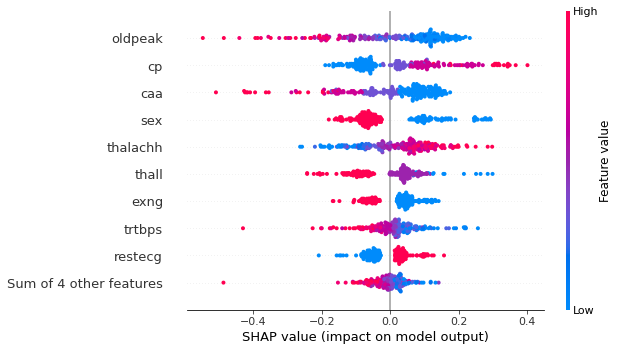


Printing Summary SHAP Bar Plot: 



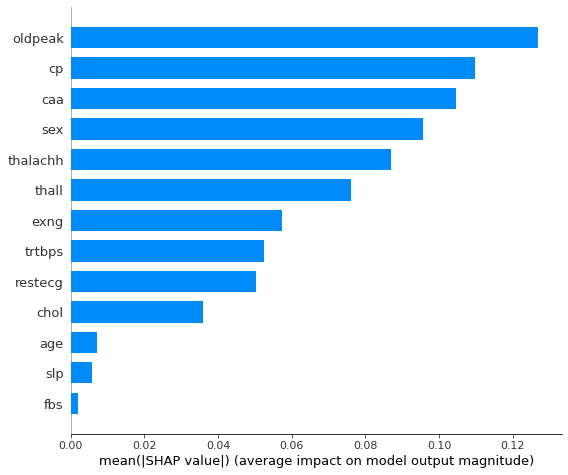


Printing Scatter SHAP Plot for All Features: 



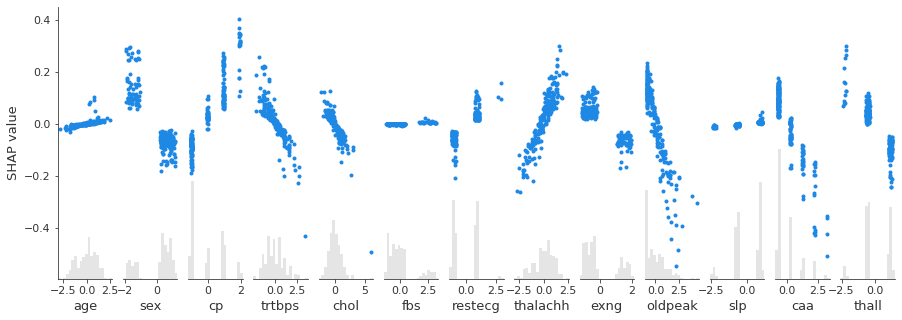


Printing Scatter SHAP Plot Between Features: 



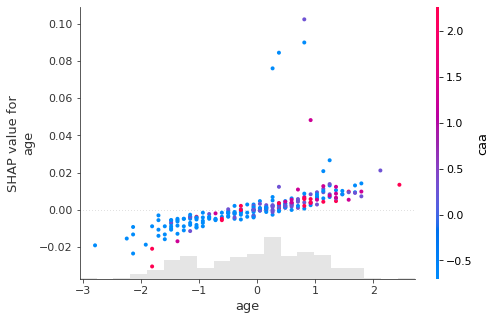

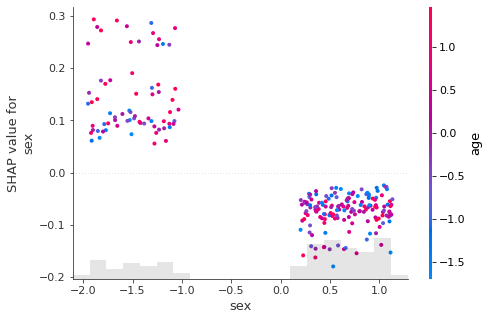

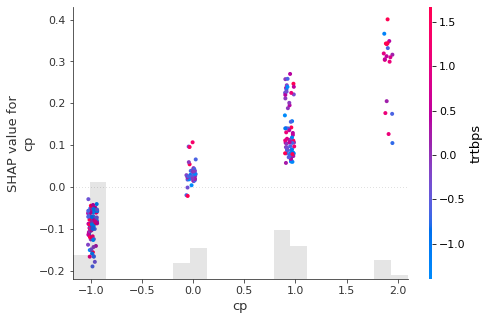

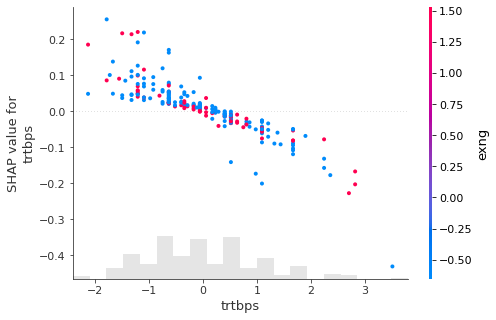

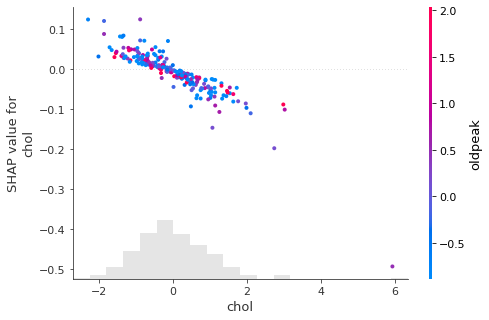

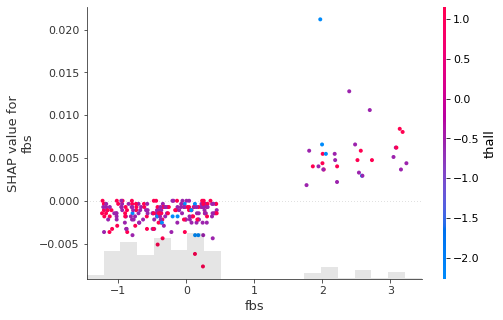

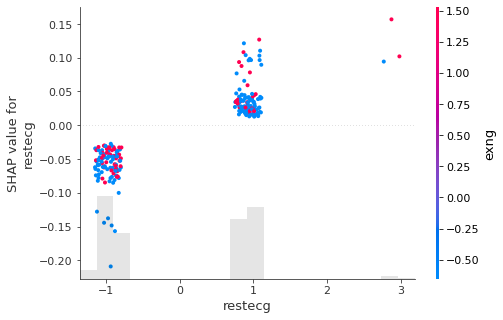

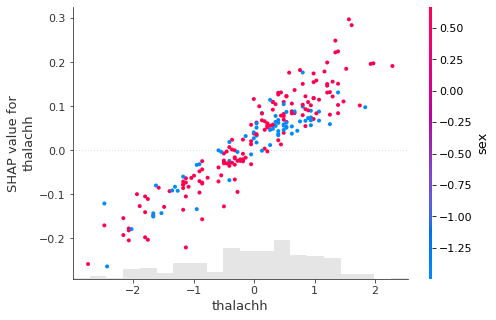

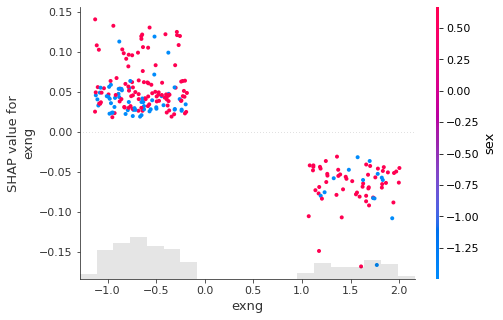

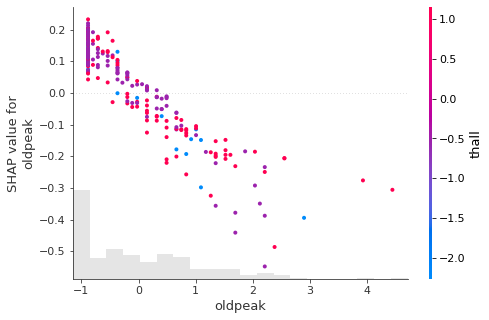

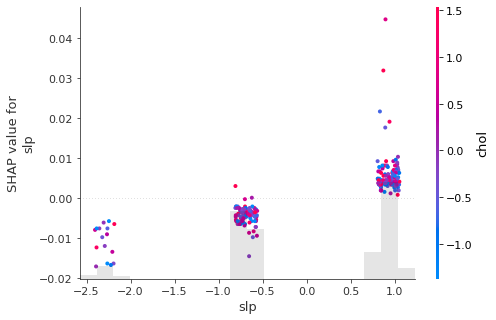

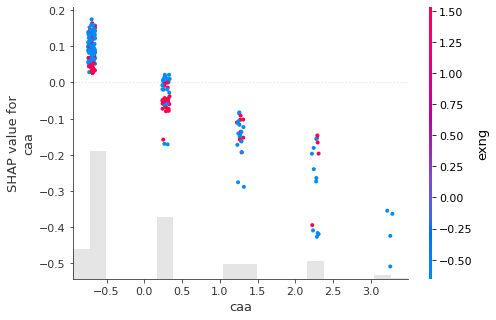

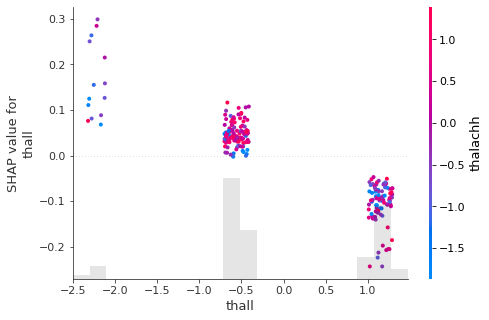


Printing Bar SHAP Plot for Local, Instance-Wise Effects: 



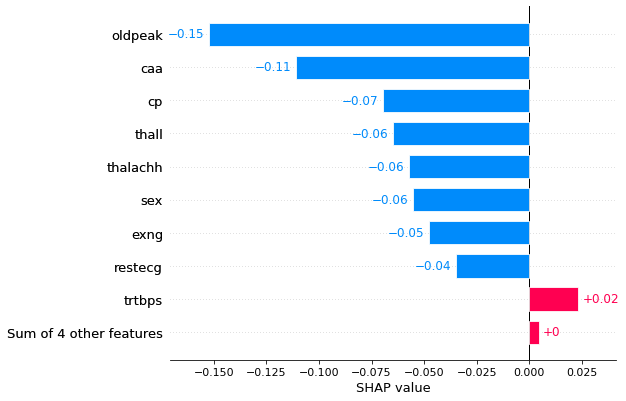


Printing Waterfall SHAP Plot for Local, Instance-Wise Effects: 



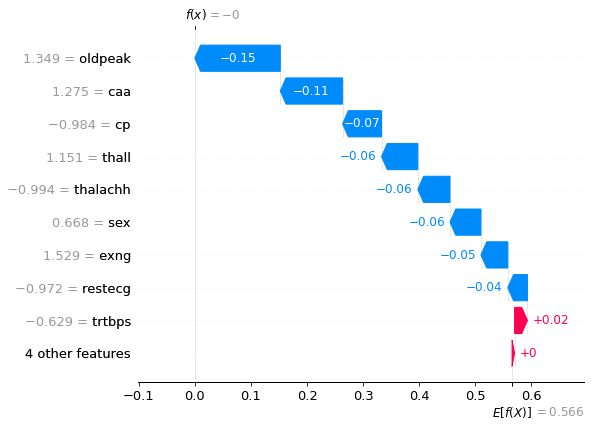


Printing Force SHAP Plot for Local, Instance-Wise Effects: 



In [11]:
#  Phase 5a: Finding 'best' way to represent dataset using SHAP visualizations
#  NOTE: Please do not take values as is, this is only a rough implementation of a LR model
#        Goal of this project is to show various ways SHAP can explain (and show) contribution
#                of each feature in the dataset




# for-loop goes through shap_values which stores .base_values, .values, .data while also looping
#            through feature_names to assign respective shap_value to its corresponding feature name
# Break the inner loop to execute string based on length of the feature_names array or else inner-loop
#            will repeat string format all # of times of length in feature_names
# The shap_values variable will have three attributes: .values, .base_values and .data.
# The .data attribute is simply a copy of the input data, .base_values is the expected value of the 
#            target, or the average target value of all the train data, and .values are the SHAP 
#            values for each example.
# If we are only interested in the SHAP values, we can use the explainer.shap_values() method

# If we are only interested in the SHAP values, we can use the explainer.shap_values() method:
print('\nArray of SHAP values with added feature_names: ')
for name in feature_names: 
    print('\n')
    for value in shap_values:
        print('"{}" data and values \n{}'.format(name, value))
        break



# By default, a SHAP beeswarm plot will take the mean absolute value of each feature
#             over all the instances (rows) of the dataset
# Each point on the chart is one SHAP value for a prediction and feature
# Red color means higher value of a feature. Blue means lower value of a feature.
# We can get the general sense of features' directionality impact based on the distribution of 
#            the red and blue dots
print('\nPrinting Beeswarm SHAP Plot: \n')
shap.plots.beeswarm(shap_values)


# In this chart, the x-axis stands for the SHAP value and the y-axis has all the features
print('\nPrinting Summary SHAP Bar Plot: \n')
shap.summary_plot(shap_values, feature_names, plot_type='bar')



# Interesting SHAP scatter plot summary of all SHAP values for each feature
print('\nPrinting Scatter SHAP Plot for All Features: \n')
shap.plots.scatter(shap_values[:,:])


# for-loop for SHAP scatter plots to show correlation between different features
print('\nPrinting Scatter SHAP Plot Between Features: \n')
for feature in feature_names:
    shap.plots.scatter(shap_values[:, feature], color=shap_values)
    
    
# For analysis of local, instance-wise effects, we can use the following plots on single 
#              observations using "shap_values[0]". 
print('\nPrinting Bar SHAP Plot for Local, Instance-Wise Effects: \n')
shap.plots.bar(shap_values[0])


# The waterfall plot has the same information, represented in a different manner. 
# Here we can see how the sum of all the SHAP values equals the difference between 
#              the prediction f(x) and the expected value E[f(x)].
print('\nPrinting Waterfall SHAP Plot for Local, Instance-Wise Effects: \n')
shap.plots.waterfall(shap_values[0])


# In this plot the positive SHAP values are displayed on the left side and the negative on the 
#              right side, as if competing against each other. The highlighted value is the 
#              prediction for that observation.
# Note that this is for a single instance 
print('\nPrinting Force SHAP Plot for Local, Instance-Wise Effects: \n')
shap.plots.force(shap_values[0])




In [12]:
# References to put code together, compile, and test run of a Logistic Regression model using SHAP
#           Splitting CSV Into Trainand Test Data by Nishank Sharma: https://medium.com/themlblog/splitting-csv-into-train-and-test-data-1407a063dd74
#           Logistic Regression in Python by Mirko Stojiljkovic: https://realpython.com/logistic-regression-python/
#           How to interpret machine learning (ML) models with SHAP values by Xiaoyou Wang: https://www.mage.ai/blog/how-to-interpret-explain-machine-learning-models-using-shap-values
#           SHAP explainer and models: https://www.mage.ai/blog/how-to-interpret-explain-machine-learning-models-using-shap-values
#           Dataset taken from: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?resource=download
#           scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#           SHAP Force Plots for Classification by Max Steele: https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195
#           Machine Learning - Logistic Regression with Python by Nikhil Adithyan: https://medium.com/codex/machine-learning-logistic-regression-with-python-5ed4ded9d146